In [1]:
from pathlib import Path
import re
from stitching import Stitcher
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import time
import glob
from reolink_api_client import ReolinkAPIClient

In [2]:
# -------- helpers --------
def pose_num(path):
    m = re.search(r"pose_(\d+)", path.stem)
    return int(m.group(1)) if m else 0

def to_pil_rgb(img):
    # library may return numpy array in BGR
    if isinstance(img, np.ndarray):
        if img.ndim == 3 and img.shape[2] == 3:
            img = img[:, :, ::-1]
        return Image.fromarray(img)
    return img  # already PIL

In [3]:
# ---------- helpers ----------
def load_bgr(path):
    im = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(str(path))
    return im

def select_subset_by_stride(paths, stride=2):
    return paths[::max(1, int(stride))]

def select_subset_by_redundancy(paths, min_shift_px=400, min_inliers=60, max_size=960):
    """
    Keep the first image. For each next candidate, match to the last kept image at small size,
    estimate homography, and discard if the image center shift is small.
    """
    if not paths:
        return []
    kept = [paths[0]]
    # prepare ORB for speed
    orb = cv2.ORB_create(nfeatures=4000)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    def resize_keep_aspect(img, max_w=max_size):
        h, w = img.shape[:2]
        if w <= max_w:
            return img, 1.0
        s = max_w / float(w)
        new = cv2.resize(img, (max_w, int(h * s)), interpolation=cv2.INTER_AREA)
        return new, s

    def keydesc(img):
        k, d = orb.detectAndCompute(img, None)
        return k, d

    last_img = load_bgr(kept[-1])
    last_small, s_last = resize_keep_aspect(last_img)
    k_last, d_last = keydesc(last_small)

    for p in paths[1:]:
        img = load_bgr(p)
        small, s = resize_keep_aspect(img)
        k, d = keydesc(small)
        if d is None or d_last is None or len(k) < 10 or len(k_last) < 10:
            kept.append(p)
            last_small, k_last, d_last = small, k, d
            continue

        # knn matches and ratio test
        raw = bf.knnMatch(d, d_last, k=2)
        good = [m for m, n in raw if m.distance < 0.75 * n.distance]
        if len(good) < min_inliers:
            kept.append(p)
            last_small, k_last, d_last = small, k, d
            continue

        # homography and center shift
        src = np.float32([k[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst = np.float32([k_last[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 3.0)
        if H is None:
            kept.append(p)
            last_small, k_last, d_last = small, k, d
            continue

        h, w = small.shape[:2]
        center = np.array([[[w * 0.5, h * 0.5]]], dtype=np.float32)
        ctr_warp = cv2.perspectiveTransform(center, H)[0, 0]
        shift = float(np.linalg.norm(ctr_warp - center[0, 0]))
        if shift >= min_shift_px * (small.shape[1] / max_size):
            kept.append(p)
            last_small, k_last, d_last = small, k, d
        # else, skip as redundant

    return kept

In [4]:
# -------- config --------

detector = "sift"               # "sift" is robust, "orb" is faster
confidence_threshold = 0.35      # relax if you see gaps
try_affine_fallback = True      # try a gentler affine model if the default fails
max_width_px = None             # set for downscale, for example 8000, or keep None
FOV_DEG = 54.2


captures/192.168.255.26/169.254.40.1/images
Total frames: 19  after stride: 10  after redundancy filter: 10
Subset sample: ['pose_30.jpg', 'pose_32.jpg', 'pose_34.jpg', 'pose_36.jpg', 'pose_38.jpg', 'pose_40.jpg'] ...


/Users/mateo/pyronear/deploy/pyro-engine/.venv/lib/python3.11/site-packages/stitching/subsetter.py:32: StitchingWarning: Not all images are included in the final panorama. If this is not intended, use the 'matches_graph_dot_file' parameter to analyze your matches. You might want to lower the 'confidence_threshold' or try another 'detector' to include all your images.
  warnings.warn(


Saved full size panorama: captures/192.168.255.26/169.254.40.1/panorama_full.jpg


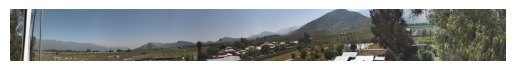

captures/192.168.255.26/169.254.40.3/images
Total frames: 19  after stride: 10  after redundancy filter: 10
Subset sample: ['pose_30.jpg', 'pose_32.jpg', 'pose_34.jpg', 'pose_36.jpg', 'pose_38.jpg', 'pose_40.jpg'] ...


/Users/mateo/pyronear/deploy/pyro-engine/.venv/lib/python3.11/site-packages/stitching/subsetter.py:32: StitchingWarning: Not all images are included in the final panorama. If this is not intended, use the 'matches_graph_dot_file' parameter to analyze your matches. You might want to lower the 'confidence_threshold' or try another 'detector' to include all your images.
  warnings.warn(


Saved full size panorama: captures/192.168.255.26/169.254.40.3/panorama_full.jpg


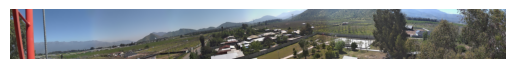

In [5]:
PI_IP = "192.168.255.26"
cams = glob.glob(f"captures/{PI_IP}/*")
for cam in cams:
    cam = cam.split('/')[-1]
    folder = Path(f"captures/{PI_IP}") / f"{cam}/images"
    print(folder)

    # ---------- choose input set ----------
    paths = [p for p in folder.glob("*.jpg") if not p.name.startswith("panorama")]
    paths = sorted(paths, key=pose_num)
    if not paths:
        raise SystemExit(f"No JPG files found in {folder}")

    # first reduce by stride, then filter redundancy
    paths_stride = select_subset_by_stride(paths, stride=2)
    paths_subset = select_subset_by_redundancy(
        paths_stride,
        min_shift_px=350,
        min_inliers=50,
        max_size=960
    )

    print(f"Total frames: {len(paths)}  after stride: {len(paths_stride)}  after redundancy filter: {len(paths_subset)}")
    print("Subset sample:", [p.name for p in paths_subset[:6]], "...")

    # ---------- stitch ----------
    detector = "sift"
    confidence_threshold = 0.2
    stitcher = Stitcher(
        detector=detector,
        nfeatures=6000,
        range_width=6,
        confidence_threshold=confidence_threshold,
        blender_type="multiband",
        blend_strength=5
    )

    panorama = stitcher.stitch([str(p) for p in paths_subset])

    # convert to PIL
    if isinstance(panorama, np.ndarray):
        panorama = panorama[:, :, ::-1]
        pano_img = Image.fromarray(panorama)
    else:
        pano_img = panorama

    # save full panorama only
    output_dir = folder.parent
    out_original = output_dir / "panorama_full.jpg"
    pano_img.save(out_original, quality=95)

    print(f"Saved full size panorama: {out_original}")

    plt.imshow(pano_img)
    plt.axis("off")
    plt.show()
